In [1]:
%matplotlib inline

<div class="document" id="gabor-filter-banks-for-texture-classification">
<h1 class="title">Gabor filter banks for texture classification</h1>
<p>In this example, we will see how to classify textures based on Gabor filter
banks. Frequency and orientation representations of the Gabor filter are
similar to those of the human visual system.</p>
<p>The images are filtered using the real parts of various different Gabor filter
kernels. The mean and variance of the filtered images are then used as features
for classification, which is based on the least squared error for simplicity.</p>
</div>


In [20]:
# https://www.quora.com/Computer-Vision/What-is-a-GIST-descriptor
# http://ilab.usc.edu/siagian/Research/Gist/Gist.html

Given an input image, a GIST descriptor is computed by
1.  Convolve the image with 32 Gabor filters at 4 scales, 8 orientations, producing 32 feature maps of the same size of the input image.
2.  Divide each feature map into 16 regions (by a 4x4 grid), and then average the feature values within each region.
3.  Concatenate the 16 averaged values of all 32 feature maps, resulting in a 16x32=512 GIST descriptor.
Intuitively, GIST summarizes the gradient information (scales and orientations) for different parts of an image, which provides a rough description (the gist) of the scene.

Reference:
1.  Modeling the shape of the scene: a holistic representation of the spatial envelope

In [9]:
import cv2
import math

In [8]:
#### helper function for ipython

def implot(im, gray=False):
    cv_rgb = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    #plt.show()
    
def np2to3(im):
    # convert 2d to 3d naively
    new_im = np.zeros((im.shape[0], im.shape[1], 3))
    r, c = im.shape
    for x in range(r):
        for y in range(c):
            new_im[x, y, :] = im[x,y]
    return new_im

In [10]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

import scipy.misc

# get the closest image to the tram

def ssd(imageA, imageB):
    """
    ssd based from code in assignment 11
    """
    ssd = np.sum(np.square((imageA.astype("float") - imageB.astype("float"))))        
    return ssd
    
    


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

def make_square(img):
    """turns an image into a square
    assumes the image is grayscale
    
    for sides divisible by 4
    """
    r, c = img.shape
    
    side4 = (int(max([r,c])/4)) * 4
    
    return cv2.resize(img, (side4, side4))
    
    one_edge = side4/2
    img1 = img[((r/2)-one_edge):((r/2)+one_edge), ((c/2)-one_edge):((c/2)+one_edge)]
    
    r, c = img1.shape
    return img1[:min([r,c]), :min([r,c])]


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


img_name = 'brick.png'
img_name = 'C:/Users/chapm/Desktop/GIST-python/apple.jpg'
            
shrink = (slice(0, None, 3), slice(0, None, 3))
#brick = img_as_float(data.load('brick.png'))[shrink]

img_name = 'apple.jpg'
img_name = 'hk.jpg'
apple = cv2.imread(img_name, cv2.COLOR_GRAY2BGR) # shrink makes the image smaller...
apple = make_square(apple)
images = apple/255.0

# prepare reference features
ref_feats = compute_feats(images, kernels)

In [15]:
feats = compute_feats(ndi.rotate(images, angle=190, reshape=False), kernels)

In [16]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

In [17]:
def compute_avg(img):
    img = make_square(img)

    r,c = img.shape

    chunks_row = np.split(np.array(range(r)), 4)
    chunks_col = np.split(np.array(range(c)), 4)

    grid_images = []

    for row in chunks_row:
        for col in chunks_col:
            grid_images.append(np.mean(img[np.min(row):np.max(row), np.min(col):np.max(col)]))
    return np.array(grid_images).reshape((4,4))

In [18]:
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1, 2, 3, 4, 5, 6, 7):
    theta = theta / 8. * np.pi
    for frequency in (0.1, 0.2, 0.3, 0.4):
    #for frequency in (0.1, 0.2, 0.4, 0.6, 0.8):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, power(images, kernel)))

In [19]:
gabor_stuff = results

def plot_single(gs):
    (kernel, powers) = gs
    a = (kernel * 255).astype(np.uint8)
    plt.figure()
    plt.imshow(a, 'gray')
    
def power_single(gs):
    (kernel, powers) = gs
    return powers*255

In [20]:
def get_gist_descriptor(gabor_stuff):
    return np.array([compute_avg(power_single(img)) for img in gabor_stuff])

In [21]:
test = get_gist_descriptor(gabor_stuff)

In [22]:
def compute_gist_descriptor(img_loc):
    # build average feature map:
    
    def make_square(img):
        """turns an image into a square
        assumes the image is grayscale

        for sides divisible by 4
        """
        r, c = img.shape

        side4 = (int(min([r,c])/4)) * 4

        one_edge = side4/2
        img1 = img[((r/2)-one_edge):((r/2)+one_edge), ((c/2)-one_edge):((c/2)+one_edge)]

        r, c = img1.shape
        return img1[:min([r,c]), :min([r,c])]
    
    def compute_avg(img):
        img = make_square(img)

        r,c = img.shape

        chunks_row = np.split(np.array(range(r)), 4)
        chunks_col = np.split(np.array(range(c)), 4)

        grid_images = []

        for row in chunks_row:
            for col in chunks_col:
                grid_images.append(np.mean(img[np.min(row):np.max(row), np.min(col):np.max(col)]))
        return np.array(grid_images).reshape((4,4))
        
    def power_single(gs):
        (kernel, powers) = gs
        return powers*255

    images = cv2.imread(img_loc, cv2.COLOR_GRAY2BGR) # shrink makes the image smaller...
    images = make_square(images)
    images = images/255.0
    
    # Plot a selection of the filter bank kernels and their responses.
    results = []
    kernel_params = []    
    
    for theta in (0, 1, 2, 3, 4, 5, 6, 7):
        theta = theta / 8. * np.pi
        for frequency in (0.1, 0.2, 0.3, 0.4):
        #for frequency in (0.1, 0.2, 0.4, 0.6, 0.8):
            kernel = gabor_kernel(frequency, theta=theta)
            params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
            kernel_params.append(params)
            # Save kernel and the power image for each image
            results.append((kernel, power(images, kernel)))
    return np.array([compute_avg(power_single(img)) for img in results]).reshape(512,)

In [23]:
def compute_gist_descriptor3(img_loc):
    # build average feature map:
    
    def make_square(img):
        """turns an image into a square
        assumes the image is grayscale

        for sides divisible by 4
        """
        r, c = img.shape

        side4 = (int(min([r,c])/4)) * 4

        one_edge = side4/2
        img1 = img[((r/2)-one_edge):((r/2)+one_edge), ((c/2)-one_edge):((c/2)+one_edge)]

        r, c = img1.shape
        return img1[:min([r,c]), :min([r,c])]
    
    def compute_avg(img):
        img = make_square(img)

        r,c = img.shape

        chunks_row = np.split(np.array(range(r)), 4)
        chunks_col = np.split(np.array(range(c)), 4)

        grid_images = []

        for row in chunks_row:
            for col in chunks_col:
                grid_images.append(np.mean(img[np.min(row):np.max(row), np.min(col):np.max(col)]))
        return np.array(grid_images).reshape((4,4))
        
    def power_single(gs):
        (kernel, powers) = gs
        return powers*255
    
    def single_gist(images):
        images = make_square(images)
        images = images/255.0
        results = []
        kernel_params = []    

        for theta in (0, 1, 2, 3, 4, 5, 6, 7):
            theta = theta / 8. * np.pi
            for frequency in (0.1, 0.2, 0.3, 0.4):
            #for frequency in (0.1, 0.2, 0.4, 0.6, 0.8):
                kernel = gabor_kernel(frequency, theta=theta)
                params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
                kernel_params.append(params)
                # Save kernel and the power image for each image
                results.append((kernel, power(images, kernel)))
        return np.array([compute_avg(power_single(img)) for img in results]).reshape(512,)        
    

    images = cv2.imread(img_loc) # shrink makes the image smaller...
    im0 = single_gist(images[:,:,0])
    im1 = single_gist(images[:,:,1])
    im2 = single_gist(images[:,:,2])   
           
    return np.hstack([im0, im1, im2])

In [24]:
test = compute_gist_descriptor3('hk.jpg')

In [25]:
im = test.reshape((16,96))

In [26]:
# build knn model...
import glob

img_data = glob.glob("im/*.jpg")


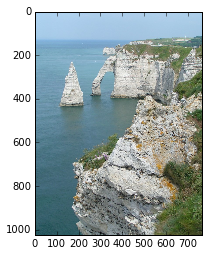

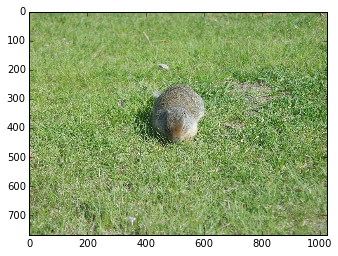

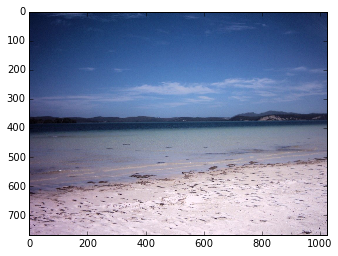

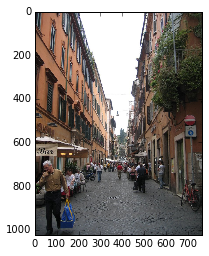

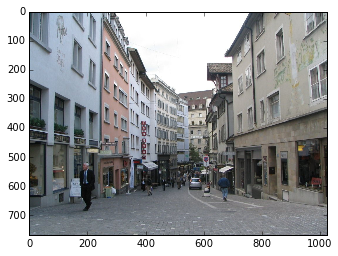

In [27]:
for im in img_data:
    plt.figure()
    img = cv2.imread(im)
    implot(img)

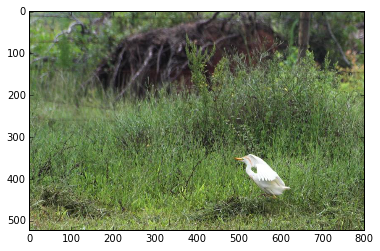

In [ ]:
base_img = cv2.imread('input2.jpg')
implot(base_img)

In [ ]:
# get the closest one....
base_gist = compute_gist_descriptor('input2.jpg')
gist_descriptors = []

for im1 in img_data:
    gd = compute_gist_descriptor(im1)
    gist_descriptors.append(ssd(gd, base_gist))


In [ ]:
best_img = cv2.imread(img_data[np.argmin(gist_descriptors)])
implot(best_img)